In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai import *
from fastai.vision import *

In [4]:
from pathlib import Path

In [5]:
path = Path('data/')
path.ls()

[PosixPath('data/sat'), PosixPath('data/road'), PosixPath('data/test.txt')]

In [6]:
path_lbl = path/'road'
path_img = path/'sat'

In [7]:
from PIL import Image
import numpy as np

In [8]:
import cv2
import numpy as np

def read_image(path):
    im = cv2.imread(str(path))
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

In [9]:
def convert_to_mask(fpath, thres=10):
    im = read_image(fpath)
    immsk = 1 * (im > 10)
    immsk = Image.fromarray(immsk[:,:,0].astype(np.uint8))
    immsk.save(fpath)
    return None

In [40]:
# for fpath in list((path/'road').iterdir()):
#     convert_to_mask(str(fpath))

## Data

In [10]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('data/sat/235_napa_sat.png'),
 PosixPath('data/sat/268_napa_sat.png'),
 PosixPath('data/sat/102_sf_sat.png')]

In [11]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('data/road/97_napa_road.png'),
 PosixPath('data/road/94_napa_road.png'),
 PosixPath('data/road/196_napa_road.png')]

In [12]:
len(lbl_names)

446

torch.Size([3, 512, 512])


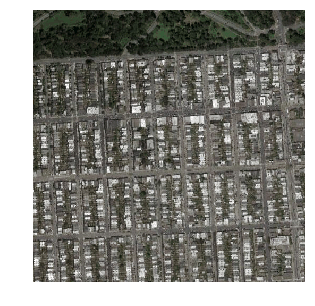

In [13]:
img_f = fnames[100]
img = open_image(img_f)
print(img.shape)
img.show(figsize=(5,5))

In [14]:
img_f

PosixPath('data/sat/29_sf_sat.png')

poor choice of naming

In [15]:
get_y_fn = lambda x: Path('/'.join(['data', 'road'] + ['_'.join(str(x).split('/')[-1].split('_')[:-1] + ['road.png'])]))

In [16]:
get_y_fn(img_f)

PosixPath('data/road/29_sf_road.png')

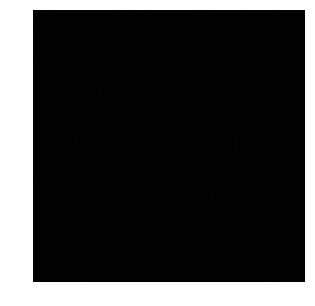

In [17]:
im_l = open_image(get_y_fn(img_f))
im_l.show(figsize=(5,5), alpha=1)

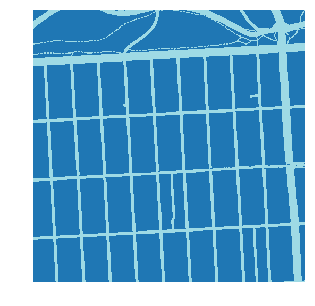

In [19]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [20]:
src_size = np.array(mask.shape[1:])
src_size, mask.data

(array([512, 512]), tensor([[[0, 0, 0,  ..., 0, 1, 1],
          [0, 0, 0,  ..., 1, 1, 1],
          [0, 0, 0,  ..., 1, 1, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 1],
          [0, 0, 0,  ..., 1, 1, 1],
          [0, 0, 0,  ..., 1, 1, 1]]]))

Need to find out all the codes present

## Datasets

In [21]:
size = src_size//2
bs = 8

In [24]:
codes = np.array(['not-road', 'road'])

Randomly selecting some data for testing and writing the name into a file

In [20]:
#!ls sat/ | shuf -n 47 > test.txt

In [25]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../test.txt')
       .label_from_func(get_y_fn, classes=codes))

In [26]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

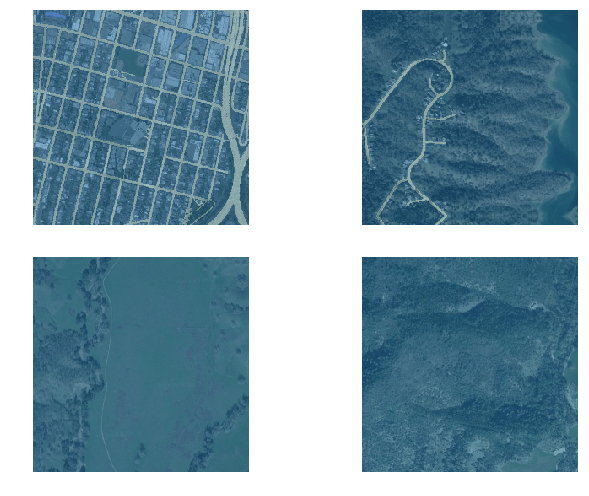

In [27]:
data.show_batch(2, figsize=(10,7))

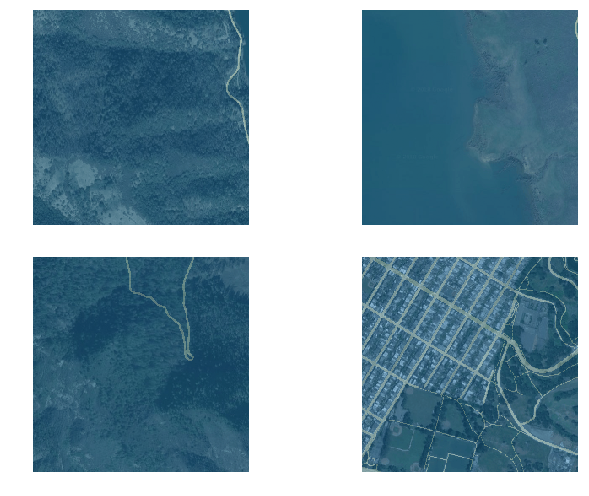

In [28]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [29]:
{v:k for k,v in enumerate(codes)}

{'not-road': 0, 'road': 1}

In [30]:
name2id = {v:k for k,v in enumerate(codes)}
# void_code = 2

def acc_map(input, target):
    target = target.squeeze(1)
    # mask = target != void_code
    return (input.argmax(dim=1)==target).float().mean()

In [31]:
metrics=acc_camvid
# metrics=accuracy

In [32]:
learn = Learner.create_unet(data, models.resnet34, metrics=metrics)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


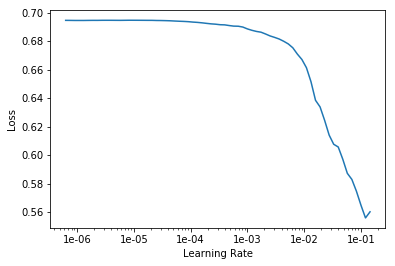

In [33]:
lr_find(learn)
learn.recorder.plot()

In [34]:
lr=1e-2

In [35]:
learn.fit_one_cycle(10, slice(lr))

Total time: 01:27
epoch  train_loss  valid_loss  acc_camvid
1      0.490679    6.331297    0.367577    (00:10)
2      0.256230    0.210449    0.913031    (00:08)
3      0.197211    0.263197    0.900614    (00:08)
4      0.166614    0.168560    0.927158    (00:08)
5      0.151350    0.136673    0.946192    (00:08)
6      0.145010    0.121513    0.952921    (00:08)
7      0.136763    0.118772    0.954277    (00:08)
8      0.128902    0.113871    0.955553    (00:08)
9      0.124165    0.111968    0.956672    (00:08)
10     0.119720    0.111509    0.956959    (00:08)



In [36]:
learn.save('stage-1')

In [37]:
learn.load('stage-1');

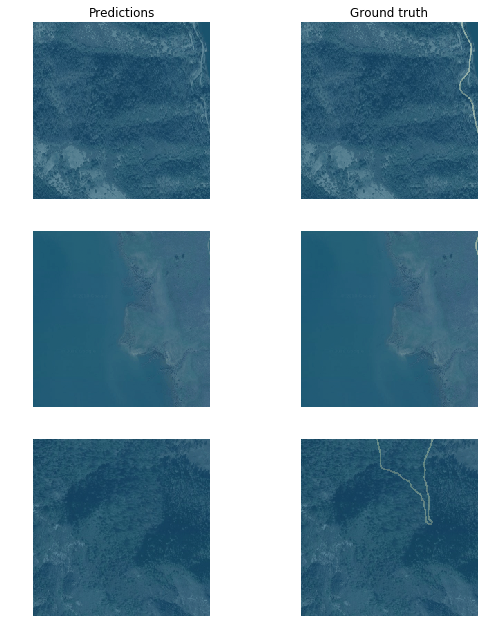

In [38]:
learn.show_results()

In [39]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


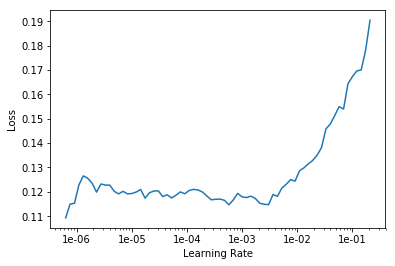

In [40]:
lr_find(learn)
learn.recorder.plot()

In [41]:
lrs = slice(1e-5,lr/5)

In [42]:
learn.fit_one_cycle(12, lrs)

Total time: 02:01
epoch  train_loss  valid_loss  acc_camvid
1      0.120066    0.110671    0.957374    (00:10)
2      0.120695    0.111235    0.957562    (00:10)
3      0.117512    0.118633    0.953706    (00:10)
4      0.119730    0.111970    0.957089    (00:10)
5      0.119177    0.117656    0.953805    (00:10)
6      0.118038    0.109012    0.957764    (00:10)
7      0.116934    0.108327    0.957891    (00:10)
8      0.115602    0.106406    0.958984    (00:10)
9      0.111015    0.113503    0.956336    (00:10)
10     0.111356    0.108448    0.958357    (00:10)
11     0.108981    0.104741    0.960008    (00:10)
12     0.111046    0.105836    0.959571    (00:10)



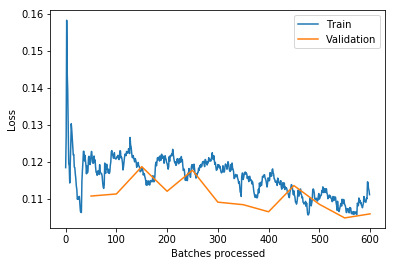

In [43]:
learn.recorder.plot_losses()

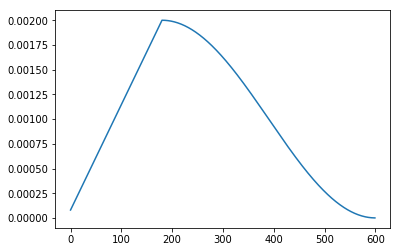

In [44]:
learn.recorder.plot_lr()

In [45]:
learn.save('stage-2');

## Go big

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [46]:
size = src_size
bs=4

In [47]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [48]:
learn = Learner.create_unet(data, models.resnet34, metrics=metrics)

In [49]:
learn.load('stage-2');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


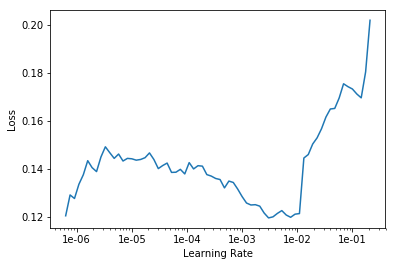

In [50]:
lr_find(learn)
learn.recorder.plot()

In [51]:
lr=1e-4

In [52]:
learn.fit_one_cycle(10, slice(lr))

Total time: 04:32
epoch  train_loss  valid_loss  acc_camvid
1      0.143098    0.114704    0.956114    (00:39)
2      0.124501    0.110868    0.957577    (00:25)
3      0.121624    0.108347    0.958276    (00:25)
4      0.125771    0.104573    0.960370    (00:25)
5      0.129221    0.105436    0.959890    (00:26)
6      0.117407    0.105183    0.960171    (00:25)
7      0.124600    0.104942    0.960042    (00:25)
8      0.119045    0.103447    0.960780    (00:25)
9      0.112703    0.103815    0.960596    (00:25)
10     0.116333    0.105237    0.959928    (00:25)



In [53]:
learn.save('stage-1-big')

In [54]:
learn.load('stage-1-big');

In [55]:
learn.unfreeze()

In [56]:
lrs = slice(1e-6,lr)

In [57]:
learn.fit_one_cycle(10, lrs, wd=1e-3)

Total time: 05:06
epoch  train_loss  valid_loss  acc_camvid
1      0.110527    0.103951    0.960641    (00:30)
2      0.113704    0.102874    0.961192    (00:30)
3      0.113726    0.101502    0.961737    (00:30)
4      0.115864    0.101116    0.961908    (00:30)
5      0.107922    0.102961    0.960866    (00:30)
6      0.110978    0.100085    0.962528    (00:30)
7      0.107193    0.100191    0.962257    (00:30)
8      0.109924    0.100248    0.962274    (00:30)
9      0.108662    0.101582    0.961698    (00:30)
10     0.105602    0.101826    0.961550    (00:30)



In [58]:
learn.save('stage-2-big')

In [59]:
learn.load('stage-2-big')

Learner(data=ImageDataBunch;
Train: LabelList
y: SegmentationLabelList (399 items)
[ImageSegment (1, 512, 512), ImageSegment (1, 512, 512), ImageSegment (1, 512, 512), ImageSegment (1, 512, 512), ImageSegment (1, 512, 512)]...
Path: data/sat
x: SegmentationItemList (399 items)
[Image (3, 512, 512), Image (3, 512, 512), Image (3, 512, 512), Image (3, 512, 512), Image (3, 512, 512)]...
Path: data/sat;
Valid: LabelList
y: SegmentationLabelList (47 items)
[ImageSegment (1, 512, 512), ImageSegment (1, 512, 512), ImageSegment (1, 512, 512), ImageSegment (1, 512, 512), ImageSegment (1, 512, 512)]...
Path: data/sat
x: SegmentationItemList (47 items)
[Image (3, 512, 512), Image (3, 512, 512), Image (3, 512, 512), Image (3, 512, 512), Image (3, 512, 512)]...
Path: data/sat;
Test: None, model=DynamicUnet(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


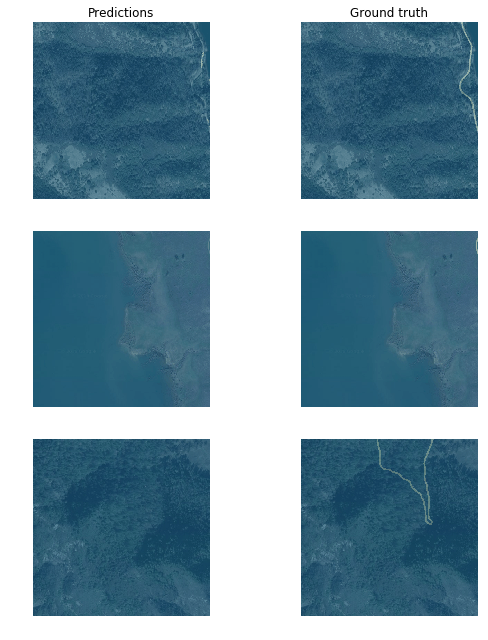

In [61]:
learn.show_results()